# Simulation-based Tests

In [14]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, scipy.stats as stats, pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample


### 1 Simulation

Hypothesis testing relies crucially on the sample distribution of the test statistics under the null hypothesis (i.e., the null distribution). If we know the null distribution (via assumptions or the null hypothesis), we can either derived the theoretical null distribution, or conduct simulation to obtain a numeric approximation of the null distribution. To demonstrate how this can be done, consider the two-sample t-test with **known** but unequal variance. 

Suppose we have two independent samples  

$$
X_1,\dots,X_{n_A}\sim\mathcal N(\mu_A,\sigma_A^2), \qquad
Y_1,\dots,Y_{n_B}\sim\mathcal N(\mu_B,\sigma_B^2),
$$
with **known** but *different* variances $\sigma_A^2\neq\sigma_B^2$.  
We wish to test  
$$H_0:\;\mu_A=\mu_B \quad\text{vs.}\quad H_1:\;\mu_A\ne\mu_B .$$

A natural statistic is  
$$
T=\frac{\bar X-\bar Y}
        {\sqrt{\sigma_A^2/n_A+\;\sigma_B^2/n_B}}.$$
Because the variances differ, $T$ under $H_0$ is **not** exactly $t$-distributed with any integer d.f.  
Instead we can **simulate $T$ under $H_0$**, and find the p-value accordingly. 


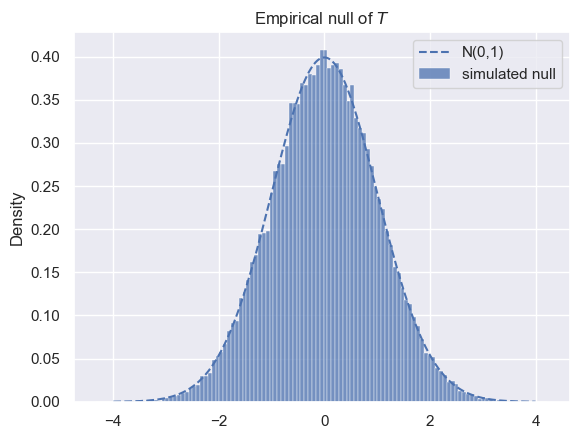

In [3]:


rng = np.random.default_rng(123)
sns.set_theme()

nA, nB = 25, 20
sigmaA, sigmaB = 1.0, 2.0          # known st.dev.
reps = 50_000
rng  = np.random.default_rng(0)

t_null = []
for _ in range(reps):
    x = rng.normal(0, sigmaA, nA)          # μ_A = μ_B = 0 under H0
    y = rng.normal(0, sigmaB, nB)
    t  = (x.mean() - y.mean()) / np.sqrt(sigmaA**2/nA + sigmaB**2/nB)
    t_null.append(t)

sns.histplot(t_null, stat="density", label="simulated null")
xs = np.linspace(-4,4,400)
plt.plot(xs, stats.norm.pdf(xs,0,1), '--', label="N(0,1)")
plt.legend(); plt.title("Empirical null of $T$")
plt.show()


In [ ]:
out = widgets.Output()

def plot_T(T=0.0):
    with out:
        clear_output(wait=True)        # erase previous frame
        p_two = (np.abs(t_null) >= abs(T)).mean()
        fig, ax = plt.subplots(figsize=(7,4))
        sns.histplot(t_null, stat="density", label="simulated null", ax=ax, color="lightskyblue")
        xs = np.linspace(-4,4,401)
        ax.plot(xs, stats.norm.pdf(xs,0,1), "--", label="N(0,1)", color="k")
        ax.axvline( T, color="crimson", lw=2)
        ax.axvline(-T, color="crimson", lw=2)
        ax.set_title(rf"Empirical null of $T$  |  chosen $T={T:.2f}$, two-sided $p={p_two:.4f}$")
        ax.set_xlabel("T statistic"); ax.set_ylabel("Density")
        ax.legend()
        plt.show()

slider = widgets.FloatSlider(value=0.0, min=0.0, max=4.0, step=0.05,
                             description="T", readout_format=".2f",
                             continuous_update=False)
widgets.interact(plot_T, T=slider)
display(out)


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='T', max=4.0, step=0.05), Ou…

Output()

### 2 Permutation

Some times we can leverage the structure (or the lack of the structure) in the data and the hypotheses to construct a test. The permutation test is a notable example of such test. The permuation test can be used to test the null hypothesis that states exchangeability. For instance, two samples come from the same distribution. As a result, we can generate the null distribution by permuting the labels. 

Here $H_0: F_X = F_Y$ and $H_a: F_X \neq F_Y$. We can define our own statistics, which can be as simple as the mean difference $\hat\delta = \bar X - \bar Y$


In [5]:
rng = np.random.default_rng(1)
Delta= 1 # true difference in means, change as needed
x = rng.normal(0.0, 1, 12)      # sample A
y = rng.normal(Delta, 1, 10)      # sample B  

obs_delta = x.mean() - y.mean()

# -- permutation null --
data  = np.r_[x, y]
nA    = len(x)
n_all = len(data)
B     = 10_000
perm_deltas = []
for _ in range(B):
    idx = rng.permutation(n_all)
    delta = data[idx[:nA]].mean() - data[idx[nA:]].mean()
    perm_deltas.append(delta)

p_perm = (np.abs(perm_deltas) >= abs(obs_delta)).mean()
print(f"Permutation p-value = {p_perm:.4f}")


Permutation p-value = 0.0188


Observed Δ = -0.530
Two-sided permutation p-value = 0.0188


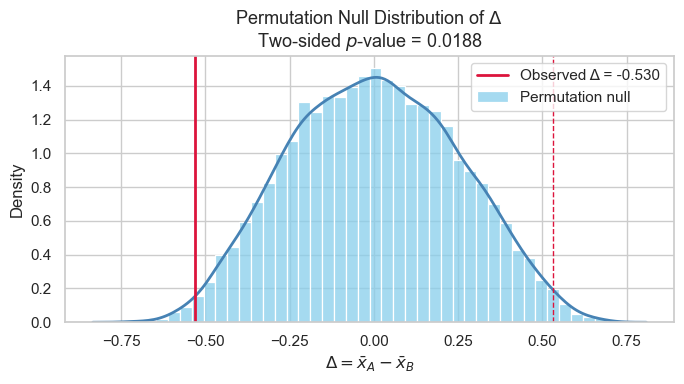

In [6]:

sns.set_theme(style="whitegrid")

# -- observed statistic (already computed above) --
print(f"Observed Δ = {obs_delta:.3f}")
print(f"Two-sided permutation p-value = {p_perm:.4f}")

# -- histogram with KDE overlay --
fig, ax = plt.subplots(figsize=(7,4))
sns.histplot(perm_deltas, bins=40, stat="density", color="skyblue",
             edgecolor="white", label="Permutation null", ax=ax)

# Kernel-density overlay (optional but looks nice)
sns.kdeplot(perm_deltas, color="steelblue", lw=2, ax=ax)

# -- vertical lines for observed statistic (±|Δ|) --
ax.axvline(obs_delta,  color="crimson", lw=2, label=f"Observed Δ = {obs_delta:.3f}")
ax.axvline(-obs_delta, color="crimson", lw=1, linestyle="--")

# -- title & annotations --
ax.set_title(
    rf"Permutation Null Distribution of $\Delta$"
    f"\nTwo-sided $p$-value = {p_perm:.4f}",
    fontsize=13
)
ax.set_xlabel(r"$\Delta = \bar{{x}}_A - \bar{{x}}_B$")
ax.set_ylabel("Density")
ax.legend()
plt.tight_layout()
plt.show()


### 3 Bootstrap

Bootstrap is one of the most powerful methods for statistical inference.  The idea is simple but elegant:
The null distribution requires repeated sampling from the true population. Although the true population is not attainable in practice, we can *use the observed samples as an approximation to the true population*. Intuitively, whatever we apply on the observed samples might be just as well as if we have the true population, when the sample size is sufficiently large (e.g., thousands or millions of samples).


Let $\{x_1,\dots,x_n\}$ be our sample and $T(\cdot)$ a statistic (e.g.\ the median). We can bootstrap the sampling distribution of the median using the following procedure. 

1. Sample with replacement ${x_1^*,\dots,x_n^*}$ from the observed data.

2. Compute $T^* = T(x_1^*,\dots,x_n^*)$.

3. Repeat Step 1 and Step 2 $B$ times yields an empirical distribution $\{T^*_1,\dots,T^*_B\}$.


In [8]:

B = 5000 # number of bootstrap samples, change as needed

rng = np.random.default_rng(2)

pop  = stats.skewnorm.rvs(6, size=100_000, random_state=rng)   # highly skewed population
sample = rng.choice(pop, 40, replace=False)

# bootstrap median

boot_median = [np.median(rng.choice(sample, 40, replace=True)) for _ in range(B)]
ci_med = np.percentile(boot_median, [2.5, 97.5])


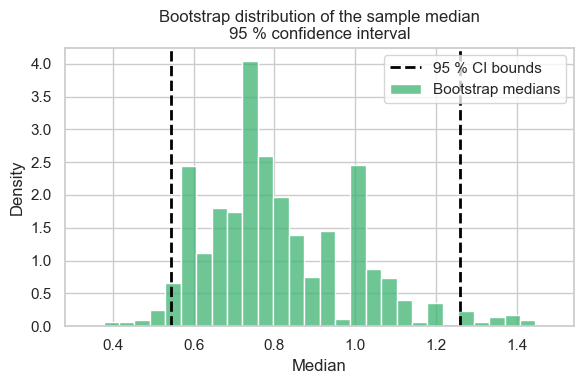

True population median: 0.6723454908961345
Bootstrap 95 % CI for median: [0.54437905 1.25943127]


In [9]:

sns.set_theme(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.histplot(
    boot_median,
    bins=30,
    stat="density",
    color="mediumseagreen",
    edgecolor="white",
    label="Bootstrap medians"
)

# vertical lines for the 95 % CI
plt.axvline(ci_med[0], color="black", linestyle="--", linewidth=2, label="95 % CI bounds")
plt.axvline(ci_med[1], color="black", linestyle="--", linewidth=2)

plt.title("Bootstrap distribution of the sample median\n95 % confidence interval")
plt.xlabel("Median")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

print("True population median:", np.median(pop))
print("Bootstrap 95 % CI for median:", ci_med)



**Example 1 – Penguin flipper length**  

Estimate the mean flipper length and bootstrapped 95 % CI.

In [10]:
rng = np.random.default_rng(0)

# load data 
penguins = sns.load_dataset("penguins").dropna(subset=["body_mass_g",
                                                       "flipper_length_mm"])
X = penguins["flipper_length_mm"].to_numpy()
y = penguins["body_mass_g"].to_numpy()

# statistic function: returns slope of resampled (x, y) pairs
def slope_stat(x, y):
    return np.polyfit(x, y, 1)[0]

boot_res = stats.bootstrap(
        data=(X, y),
        statistic=slope_stat,
        paired=True,               # resample (x, y) together
        vectorized=False,
        n_resamples=4000,
        confidence_level=0.95,
        method="percentile",
        random_state=rng
)

ci_boot = boot_res.confidence_interval
print(f"Bootstrap 95% CI for slope: [{ci_boot.low:.2f}, {ci_boot.high:.2f}] g/mm")


Bootstrap 95% CI for slope: [46.87, 52.51] g/mm


**Example 2 Confidence bands for nonparametric regression**

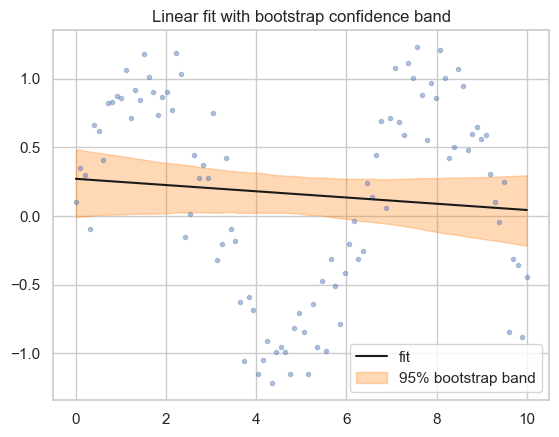

In [15]:
rng = np.random.default_rng(1)
x = np.linspace(0, 10, 100)
y = np.sin(x) + rng.normal(0, .3, size=x.size)

model = LinearRegression().fit(x[:,None], y)
y_hat = model.predict(x[:,None])

B = 1000
boot_preds = []
for _ in range(B):
    xs, ys = resample(x, y, random_state=None)
    m = LinearRegression().fit(xs[:,None], ys)
    boot_preds.append(m.predict(x[:,None]))
boot_preds = np.vstack(boot_preds)
lower, upper = np.percentile(boot_preds, [2.5, 97.5], axis=0)

plt.plot(x, y, '.', alpha=.4)
plt.plot(x, y_hat, 'k', label='fit')
plt.fill_between(x, lower, upper, color='tab:orange', alpha=.3,
                 label='95% bootstrap band')
plt.legend(); plt.title("Linear fit with bootstrap confidence band")
plt.show()